# XGBRegressor to predict participant Brier scores

## Set up

Set up the code

In [1]:
# Set up to use local modules
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..')) # Add parent directory to path
sys.path.insert(0, module_path)

In [2]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.stats import beta
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
import shap
import xgboost as xgb

# Local imports
from src import process
from src import plot

In [3]:
# Load data
blind_mode_df, estimates_df = process.load_and_process_results(
    fix_bad_rows=True, remove_bad_rows=True
)
blind_mode_feature_df = process.get_feature_df(blind_mode_df)
markets_df = process.get_current_probs()
resolution_vector = process.get_target_df(df_format=False)
estimates_matrix = process.get_estimates_matrix(blind_mode_df)
brier_score = np.mean(np.square(estimates_matrix - resolution_vector), axis=1)
blind_mode_df["brier_score"] = brier_score

# Set up data

use_only_complete_data = True
if use_only_complete_data:
    good_participants = ~blind_mode_feature_df["Age"].isna()
    blind_mode_feature_df = blind_mode_feature_df[good_participants]
    brier_score = brier_score[good_participants]
    estimates_matrix = estimates_matrix[good_participants]

# Create a new dataframe with the columns we want to use
columns_to_use = blind_mode_feature_df.columns.tolist()
blind_mode_df_xgboost = blind_mode_feature_df[columns_to_use]
blind_mode_df_xgboost.head()

# Remove rows with NaNs
# blind_mode_df_xgboost.dropna(inplace=True)
# blind_mode_df_xgboost.shape

# Create the X and y arrays
X = blind_mode_df_xgboost
# Assign the column names to the X array
y = brier_score

Loading current probabilities from file


## XGB Regressor to predict Brier score

In [4]:
# Split into train and test sets
random_seed = 1337  # random_seed = np.random.randint(100000)
print(f"Random seed: {random_seed}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=random_seed, test_size=0.2
)

Random seed: 1337


Train data


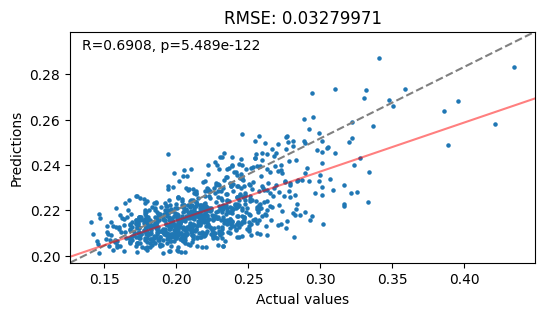

Test data


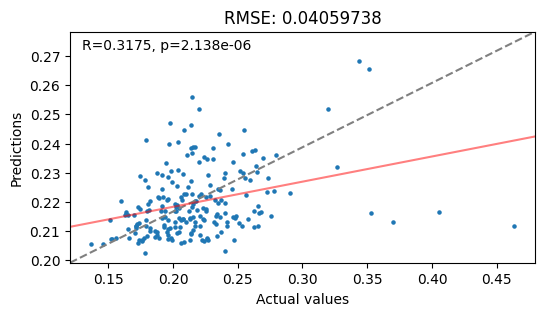

In [5]:
# Create the xgboost model
params = {
    "alpha": 0.3566354356611679,
    "gamma": 0.005997467172071246,
    "lambda": 0.370098278321425,
    "learning_rate": 0.1982493944040046,
    "min_child_weight": 3.310164889985418,
}
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, **params)
xgb_model.fit(X_train, y_train)

# Train data
y_train_pred = xgb_model.predict(X_train)
print("Train data")
fig = plt.figure(figsize=(6, 3))
ax = plot.predicted_actual_scatter(y_train, y_train_pred)
plt.show()

# Test data
y_pred_test = xgb_model.predict(X_test)
print("Test data")
fig = plt.figure(figsize=(6, 3))
ax = plot.predicted_actual_scatter(y_test, y_pred_test)
plt.show()

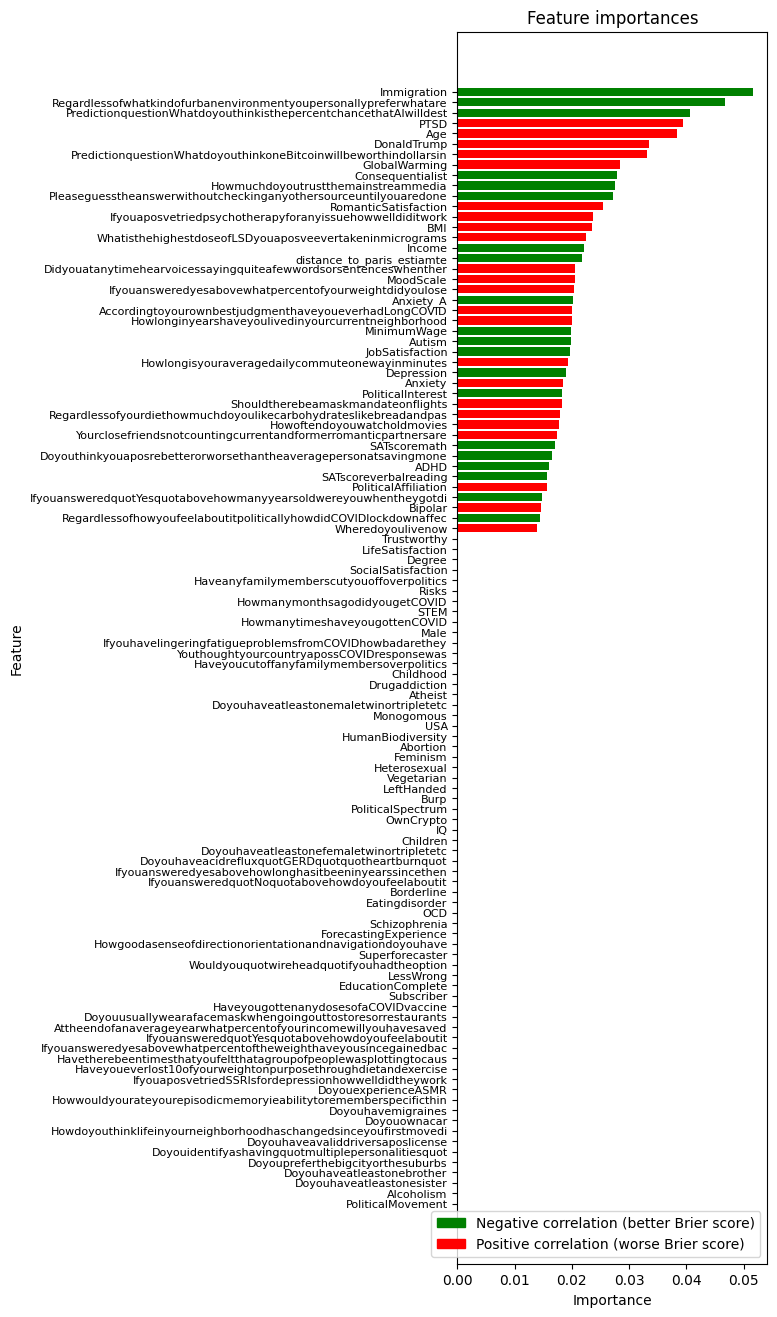

In [6]:
# Feature importance for the XGBoost model

# Get the feature importances
feature_importances = xgb_model.feature_importances_
feature_names = blind_mode_df_xgboost.columns
# Get the correlation of each feature with the brier score
feature_correlations = blind_mode_df_xgboost.corrwith(blind_mode_df["brier_score"])
colors = np.array(["green" if x < 0 else "red" for x in feature_correlations])

fig = plt.figure(figsize=(4, 16))
ax = fig.add_subplot(111)
ax.barh(
    feature_names[feature_importances.argsort()],
    feature_importances[feature_importances.argsort()],
    color=colors[feature_importances.argsort()],
)
ax.set_title("Feature importances")
ax.set_xlabel("Importance")
ax.set_ylabel("Feature")
plt.yticks(rotation=0)
# Add color legend
green_patch = mpatches.Patch(
    color="green", label="Negative correlation (better Brier score)"
)
red_patch = mpatches.Patch(
    color="red", label="Positive correlation (worse Brier score)"
)
ax.tick_params(axis="y", which="major", labelsize=8)
plt.legend(handles=[green_patch, red_patch], loc="lower right")
plt.show()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


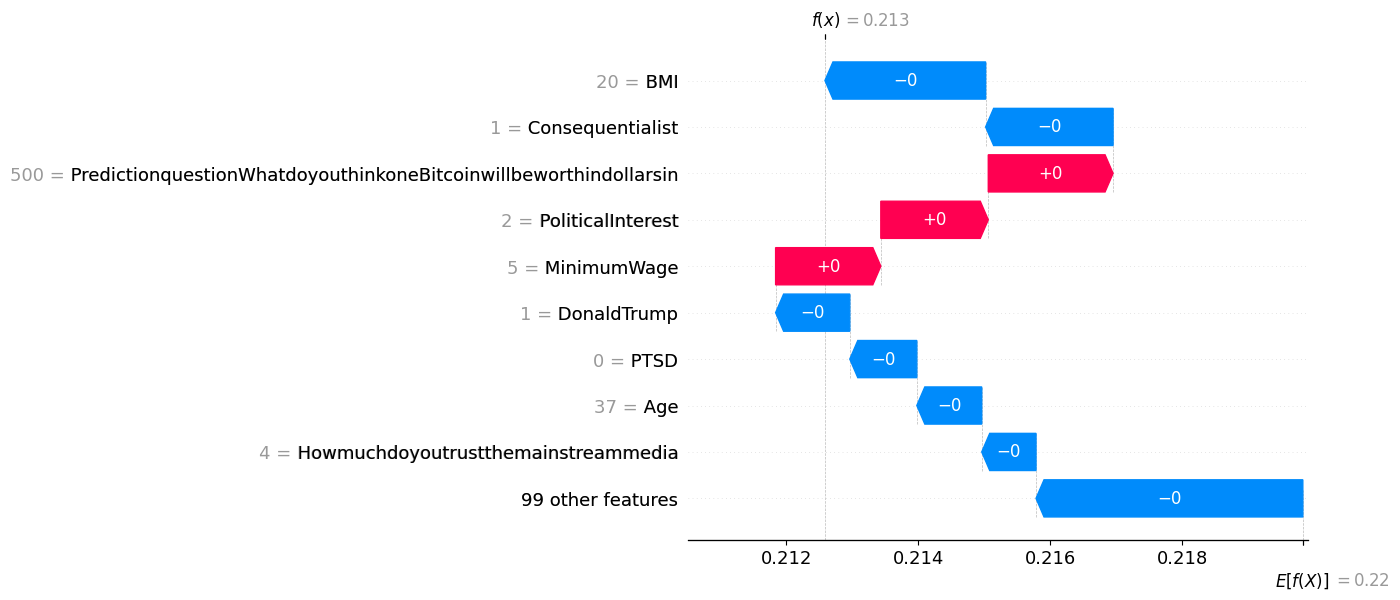

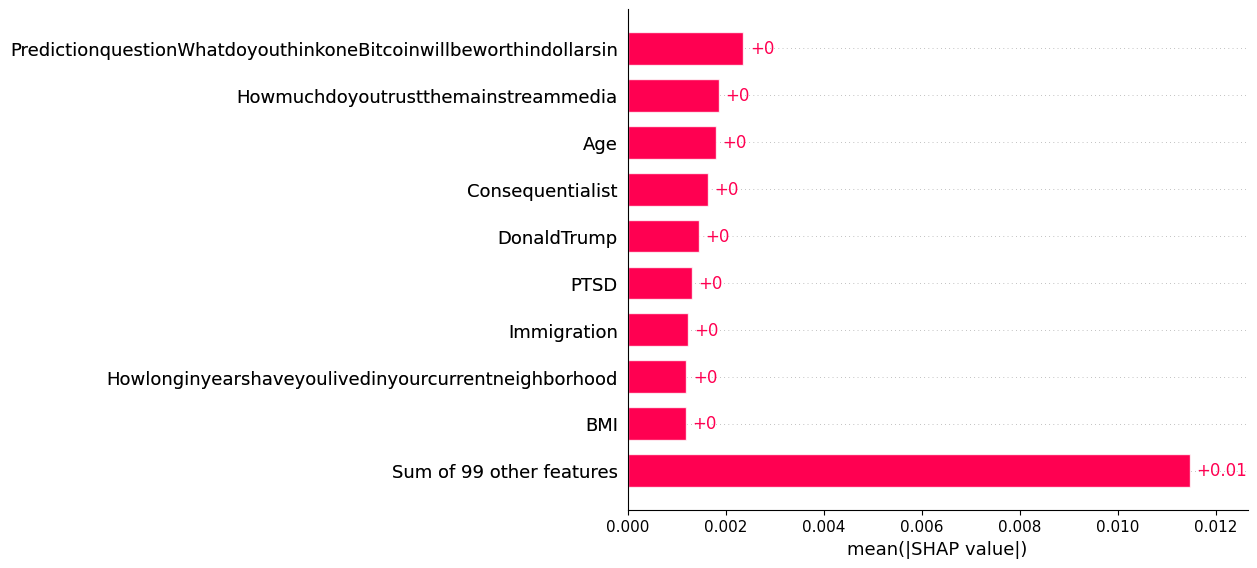

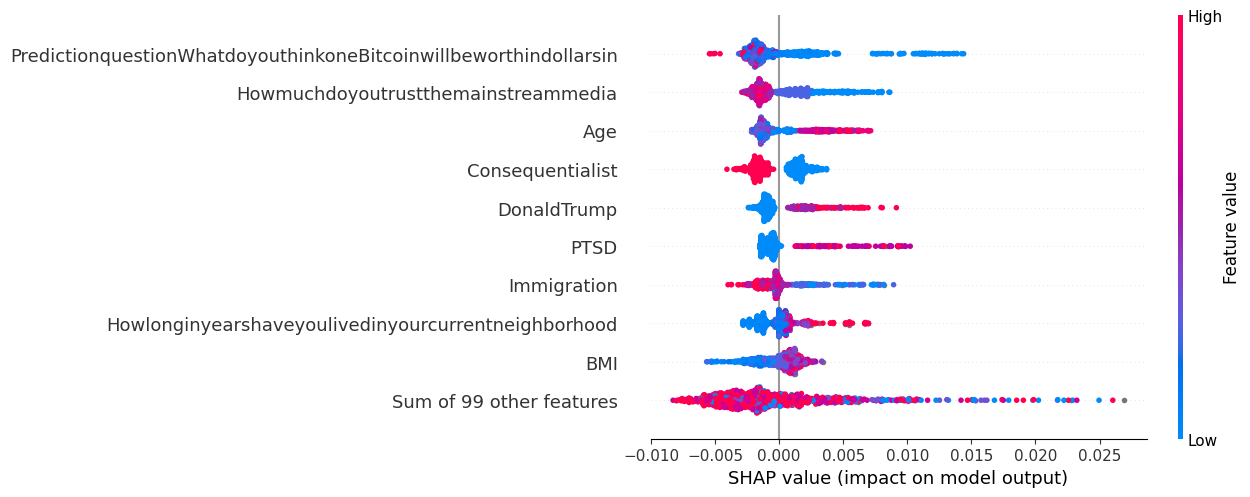

In [7]:
# SHAP

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train)

shap.plots.waterfall(shap_values[0])
shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)

In [8]:
# Sort features by their correlation with the brier score
display(blind_mode_df_xgboost.corrwith(blind_mode_df["brier_score"]).sort_values())

Immigration                                                        -0.218092
Regardlessofwhatkindofurbanenvironmentyoupersonallypreferwhatare   -0.198843
SATscoremath                                                       -0.195645
Howmuchdoyoutrustthemainstreammedia                                -0.173956
Consequentialist                                                   -0.162678
                                                                      ...   
Howlonginyearshaveyoulivedinyourcurrentneighborhood                 0.135458
Age                                                                 0.157794
GlobalWarming                                                       0.182748
PoliticalAffiliation                                                0.183539
DonaldTrump                                                         0.220889
Length: 108, dtype: float64

Random seed: 1337
Train data


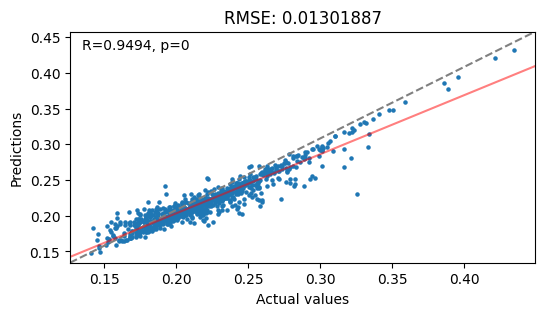

Test data


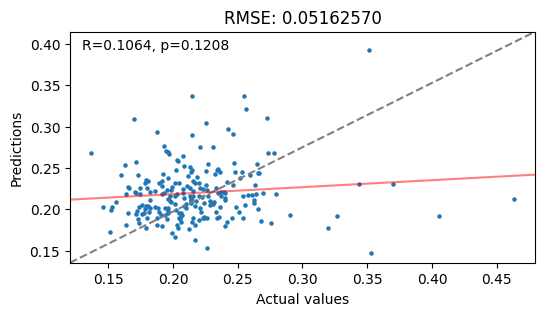

In [9]:
# Train a new XGBRegressor model, but remove the features with the bottom half
# of feature importances

# Get the feature importances
feature_importances = xgb_model.feature_importances_
feature_names = blind_mode_feature_df.columns

# Get the indices of the features sorted by importance
sorted_indices = feature_importances.argsort()
# Get the indices of the features sorted by importance, but only the top frac_to_keep
n_features_to_keep = 5
top_half_indices = sorted_indices[-n_features_to_keep:]
top_half_features_sorted = feature_names[top_half_indices]

# Create a new dataframe with the columns we want to use
columns_to_use = top_half_features_sorted.tolist()
subset_df_xgboost = blind_mode_feature_df[columns_to_use]

# Train a model as above, but with the subset of features
# Create the X and y arrays
X = subset_df_xgboost
y = brier_score

# Split into train and test sets
random_seed = np.random.randint(100000)
random_seed = 1337
print(f"Random seed: {random_seed}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=random_seed, test_size=0.2
)

# xgboost model
xgb_model_subset = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_model_subset.fit(X_train, y_train)
y_pred = xgb_model_subset.predict(X_test)

# Train data
y_train_pred = xgb_model_subset.predict(X_train)
print("Train data")
fig = plt.figure(figsize=(6, 3))
ax = plot.predicted_actual_scatter(y_train, y_train_pred)
plt.show()

# Test data
y_pred_test = xgb_model_subset.predict(X_test)
print("Test data")
fig = plt.figure(figsize=(6, 3))
ax = plot.predicted_actual_scatter(y_test, y_pred_test)
plt.show()

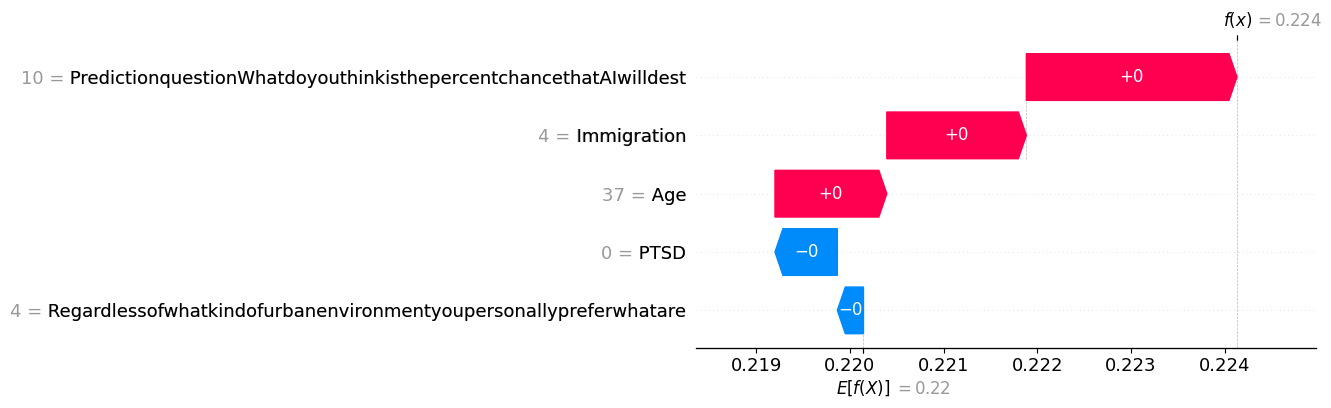

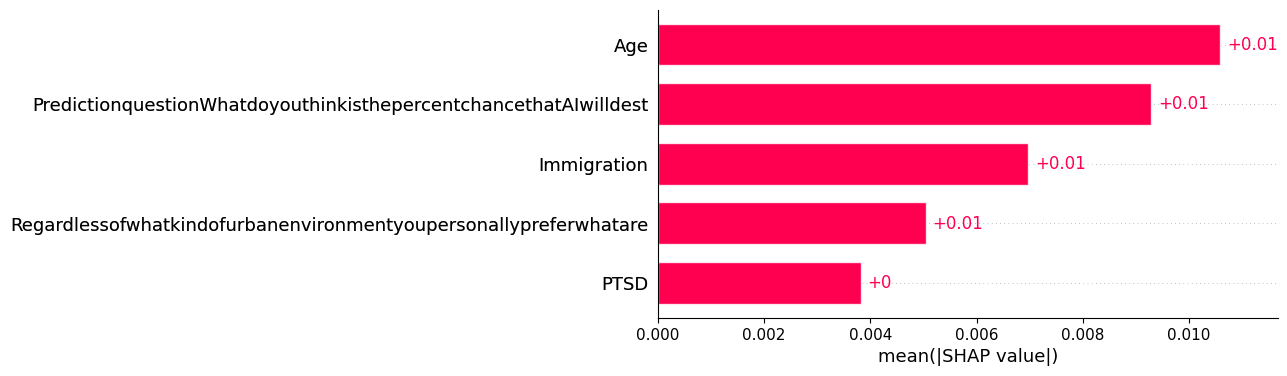

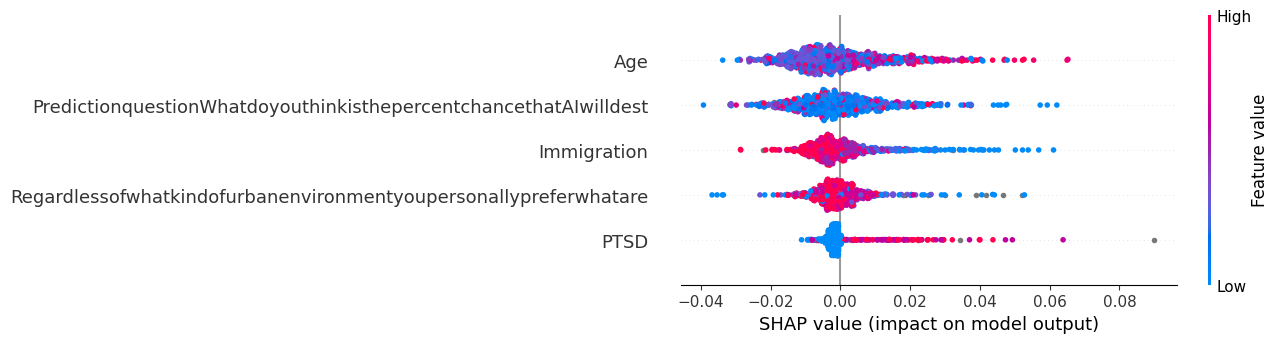

In [10]:
# Shap of the subset model

explainer = shap.Explainer(xgb_model_subset)
shap_values = explainer(X_train)

shap.plots.waterfall(shap_values[0])
shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)

## XGB Regressor for prediction aggregation

Train data


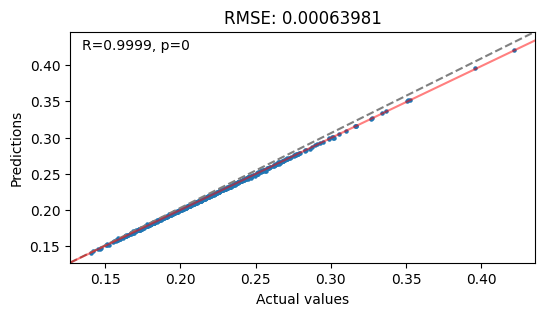

Test data


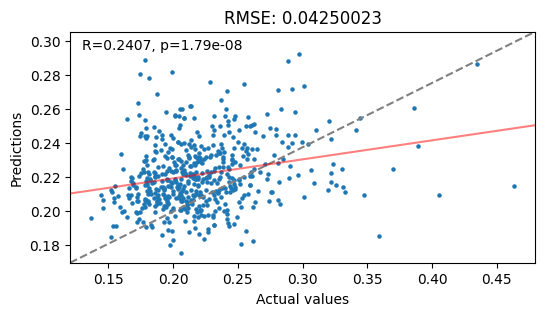

In [11]:
# Split data into features (demographic data) and target (actual outcomes)
demographic_features = blind_mode_df_xgboost.values
participant_scores = brier_score  # blind_mode_df["brier_score"].values
rng_seeds = [42, 1337]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test, ests_train, ests_test = train_test_split(
    demographic_features,
    participant_scores,
    estimates_matrix,
    random_state=rng_seeds[0],
    test_size=0.5,
)

# xgboost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=rng_seeds[1])
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# Train data
y_train_pred = xgb_model.predict(X_train)
print("Train data")
fig = plt.figure(figsize=(6, 3))
ax = plot.predicted_actual_scatter(y_train, y_train_pred)
plt.show()

# Test data
y_pred_test = xgb_model.predict(X_test)
print("Test data")
fig = plt.figure(figsize=(6, 3))
ax = plot.predicted_actual_scatter(y_test, y_pred_test)
plt.show()

In [12]:
beta_a = 1 / 3
beta_b = beta_a

In [13]:
# Run aggregation on test from above
y_pred_train = xgb_model.predict(X_train)
participant_weight_train = y_pred_train / y_pred_train.sum()
aggregate_predictions_train = np.dot(ests_train.transpose(), participant_weight_train)
aggregated_mse_train = mean_squared_error(
    aggregate_predictions_train, resolution_vector
)
print(f"Aggregation Brier score, train data: {aggregated_mse_train}")
beta_mse_train = mean_squared_error(
    beta.ppf(aggregate_predictions_train, beta_a, beta_b), resolution_vector
)
print(f"BetaArrMean Brier score, train data: {beta_mse_train}")

Aggregation Brier score, train data: 0.17742048288421153
BetaArrMean Brier score, train data: 0.1664052559180975


In [14]:
# Do same, but for test
y_pred_test = xgb_model.predict(X_test)
participant_weight_test = y_pred_test / y_pred_test.sum()
aggregate_predictions_test = np.dot(ests_test.transpose(), participant_weight_test)
aggregated_mse_test = mean_squared_error(aggregate_predictions_test, resolution_vector)
print(f"Aggregation Brier score, test data: {aggregated_mse_test}")
beta_mse_test = mean_squared_error(
    beta.ppf(aggregate_predictions_test, beta_a, beta_b), resolution_vector
)
print(f"BetaArrMean Brier score, test data: {beta_mse_test}")

Aggregation Brier score, test data: 0.17569004531476765
BetaArrMean Brier score, test data: 0.16417980444147523


In [15]:
# Find mse from the single best y_pred_test
# TODO verify that this is actually much worse than the aggregated predictions
best_y_pred_test = ests_test[np.argmax(y_pred_test), :]
best_mse = mean_squared_error(best_y_pred_test, resolution_vector)
print(f"Brier score, best test participant: {best_mse}")
beta_best_mse = mean_squared_error(
    beta.ppf(best_y_pred_test, beta_a, beta_b), resolution_vector
)
print(f"BetaArrMean, best test participant: {beta_best_mse}")

Brier score, best test participant: 0.29735
BetaArrMean, best test participant: 0.37891372223953745


In [16]:
# Mean model: mean of all participants' estimates
mean_predictions = np.mean(ests_test, axis=0)
mean_mse = mean_squared_error(mean_predictions, resolution_vector)
print(f"Brier score, mean of all participants: {mean_mse}")
beta_mean_mse = mean_squared_error(
    beta.ppf(mean_predictions, beta_a, beta_b), resolution_vector
)
print(f"BetaArrMean, mean of all participants: {beta_mean_mse}")

Brier score, mean of all participants: 0.1752491714169789
BetaArrMean, mean of all participants: 0.16366005297560335
